# Employee Promotion Modeling

**Data:** This analysis uses a simulated HR dataset that can be found on Kaggle [here](https://www.kaggle.com/datasets/arashnic/hr-ana?datasetId=1055354).

## Import Libraries

In [45]:
#The basics
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns
sns.set_style("white")
sns.set_palette(["#002f4a", "#b85741"])
from IPython.core.interactiveshell import InteractiveShell 
InteractiveShell.ast_node_interactivity = 'all'
pd.set_option('display.max_columns', None)  

#Cleaning
import missingno as msno
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer

#Modeling
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, RepeatedKFold, cross_validate
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import make_scorer, accuracy_score, confusion_matrix, roc_auc_score, recall_score, precision_score
from imblearn.over_sampling import SMOTE
from sklearn.feature_selection import mutual_info_classif
from xgboost import XGBClassifier
import statsmodels.api as sm



## Data Preview
Our training data consists of ~55k rows of employee data. Our testing data consists of ~23.5k rows of employee data. We'll explore the training data and fit a model to predict who amongst the test data should be considered for promotion. 
* There are no duplicate employee IDs
* The distributions for our variables are comparable between train and test sets.
* Both the education and previous_year_rating columns have missing values that will need to be addressed.
    * The people missing an education value are not typically the same people missing the previous year rating.
* All columns appear to have appropriate initial data types
* All numeric columns appear to have reasonable values (no inherently improbably mins/maxs)
* The promotion rate in the training set is 8.5%

In [46]:
train = pd.read_csv('train.csv')
train.shape
train.columns
train['employee_id'].nunique()
test = pd.read_csv('test.csv')
test.shape
test.columns
test['employee_id'].nunique()



(54808, 13)

Index(['employee_id', 'department', 'region', 'education', 'gender',
       'recruitment_channel', 'no_of_trainings', 'age', 'previous_year_rating',
       'length_of_service', 'awards_won?', 'avg_training_score',
       'is_promoted'],
      dtype='object')

54808

(23490, 12)

Index(['employee_id', 'department', 'region', 'education', 'gender',
       'recruitment_channel', 'no_of_trainings', 'age', 'previous_year_rating',
       'length_of_service', 'awards_won?', 'avg_training_score'],
      dtype='object')

23490

In [47]:
train.info()
train.describe()
test.info()
test.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54808 entries, 0 to 54807
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   employee_id           54808 non-null  int64  
 1   department            54808 non-null  object 
 2   region                54808 non-null  object 
 3   education             52399 non-null  object 
 4   gender                54808 non-null  object 
 5   recruitment_channel   54808 non-null  object 
 6   no_of_trainings       54808 non-null  int64  
 7   age                   54808 non-null  int64  
 8   previous_year_rating  50684 non-null  float64
 9   length_of_service     54808 non-null  int64  
 10  awards_won?           54808 non-null  int64  
 11  avg_training_score    54808 non-null  int64  
 12  is_promoted           54808 non-null  int64  
dtypes: float64(1), int64(7), object(5)
memory usage: 5.4+ MB


,employee_id,no_of_trainings,age,previous_year_rating,length_of_service,awards_won?,avg_training_score,is_promoted
count,54808.000000,54808.000000,54808.000000,50684.000000,54808.000000,54808.000000,54808.000000,54808.000000
mean,39195.830627,1.253011,34.803915,3.329256,5.865512,0.023172,63.386750,0.085170
std,22586.581449,0.609264,7.660169,1.259993,4.265094,0.150450,13.371559,0.279137
min,1.000000,1.000000,20.000000,1.000000,1.000000,0.000000,39.000000,0.000000
25%,19669.750000,1.000000,29.000000,3.000000,3.000000,0.000000,51.000000,0.000000
50%,39225.500000,1.000000,33.000000,3.000000,5.000000,0.000000,60.000000,0.000000
75%,58730.500000,1.000000,39.000000,4.000000,7.000000,0.000000,76.000000,0.000000
max,78298.000000,10.000000,60.000000,5.000000,37.000000,1.000000,99.000000,1.000000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23490 entries, 0 to 23489
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   employee_id           23490 non-null  int64  
 1   department            23490 non-null  object 
 2   region                23490 non-null  object 
 3   education             22456 non-null  object 
 4   gender                23490 non-null  object 
 5   recruitment_channel   23490 non-null  object 
 6   no_of_trainings       23490 non-null  int64  
 7   age                   23490 non-null  int64  
 8   previous_year_rating  21678 non-null  float64
 9   length_of_service     23490 non-null  int64  
 10  awards_won?           23490 non-null  int64  
 11  avg_training_score    23490 non-null  int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 2.2+ MB


,employee_id,no_of_trainings,age,previous_year_rating,length_of_service,awards_won?,avg_training_score
count,23490.000000,23490.000000,23490.000000,21678.000000,23490.000000,23490.000000,23490.000000
mean,39041.399149,1.254236,34.782929,3.339146,5.810387,0.022776,63.263133
std,22640.809201,0.600910,7.679492,1.263294,4.207917,0.149191,13.411750
min,3.000000,1.000000,20.000000,1.000000,1.000000,0.000000,39.000000
25%,19370.250000,1.000000,29.000000,3.000000,3.000000,0.000000,51.000000
50%,38963.500000,1.000000,33.000000,3.000000,5.000000,0.000000,60.000000
75%,58690.000000,1.000000,39.000000,4.000000,7.000000,0.000000,76.000000
max,78295.000000,9.000000,60.000000,5.000000,34.000000,1.000000,99.000000


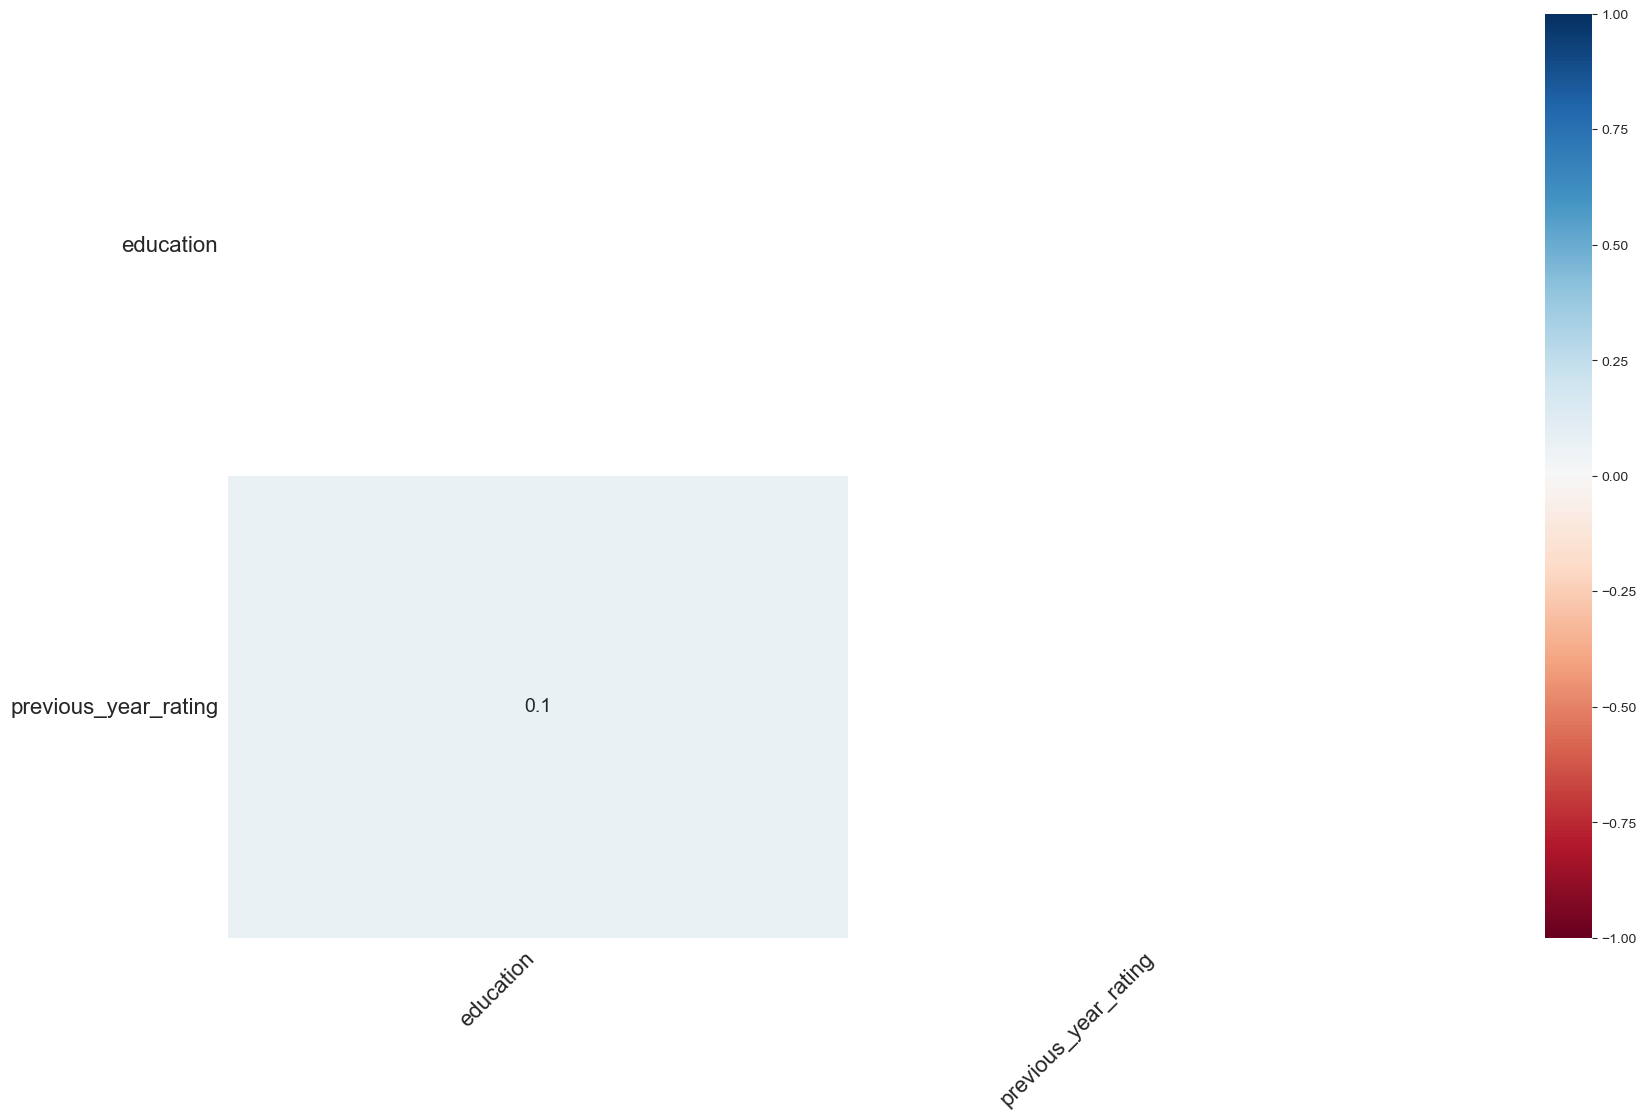

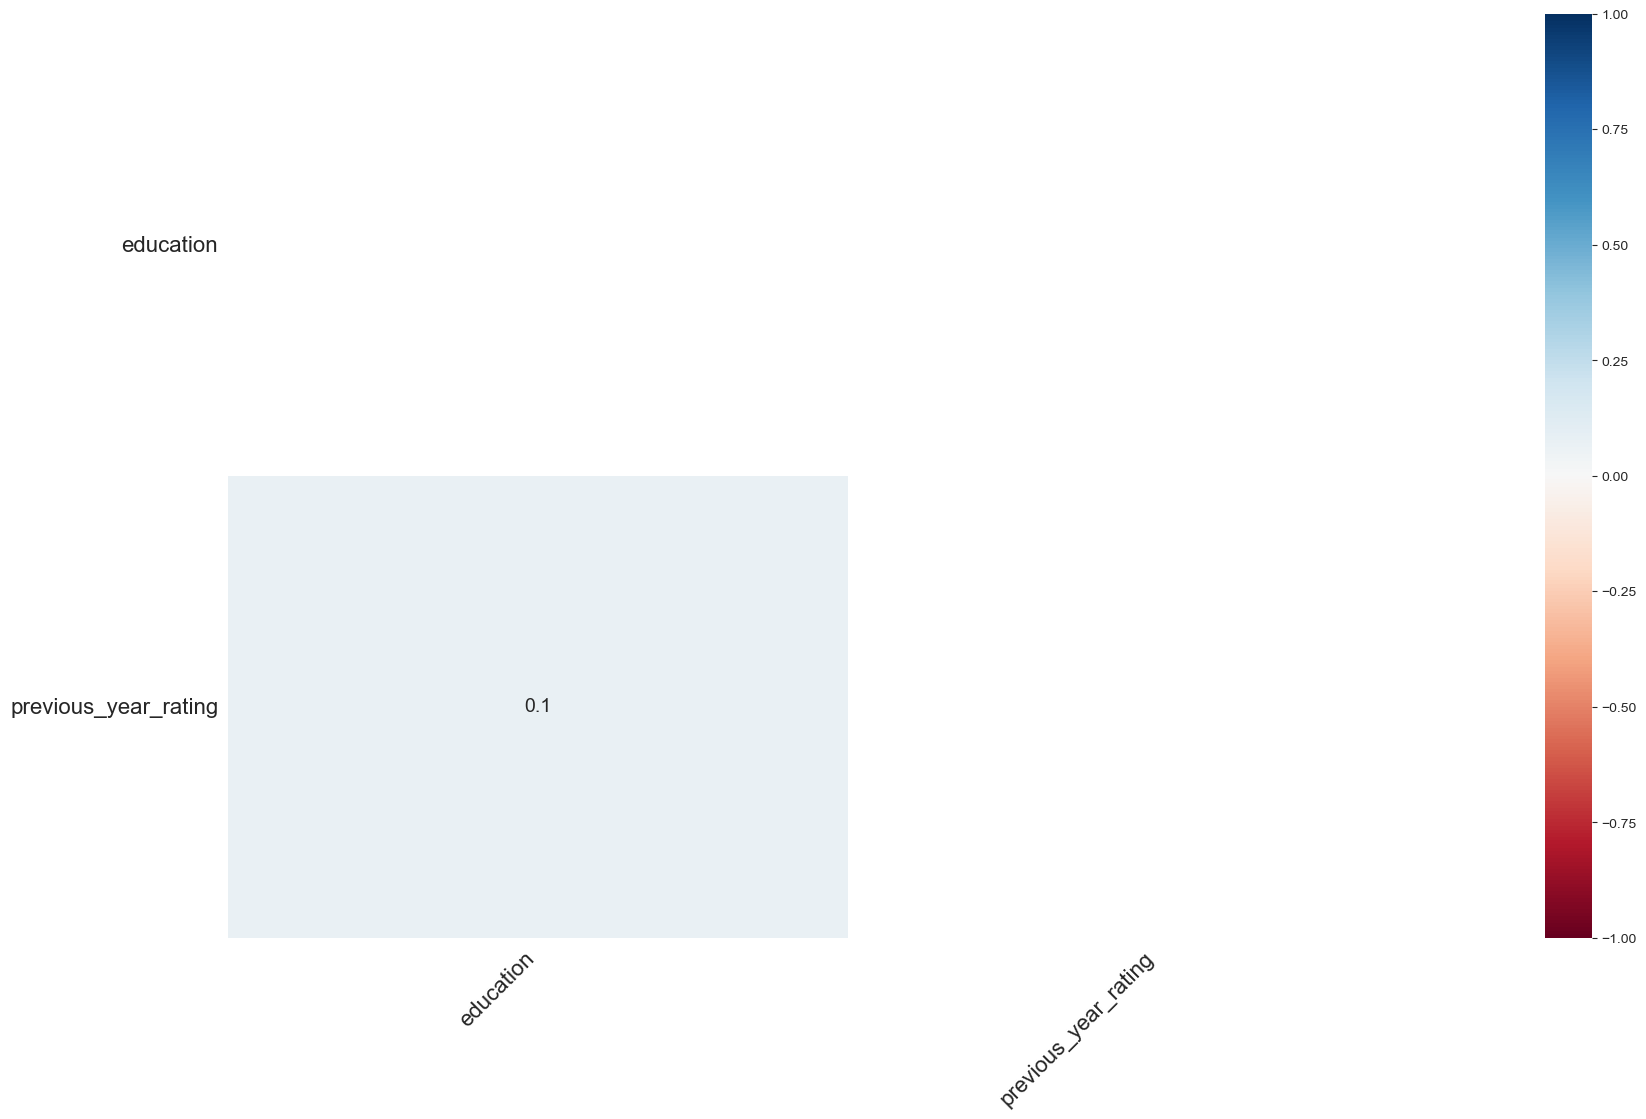

In [48]:
msno.heatmap(train);
msno.heatmap(test);

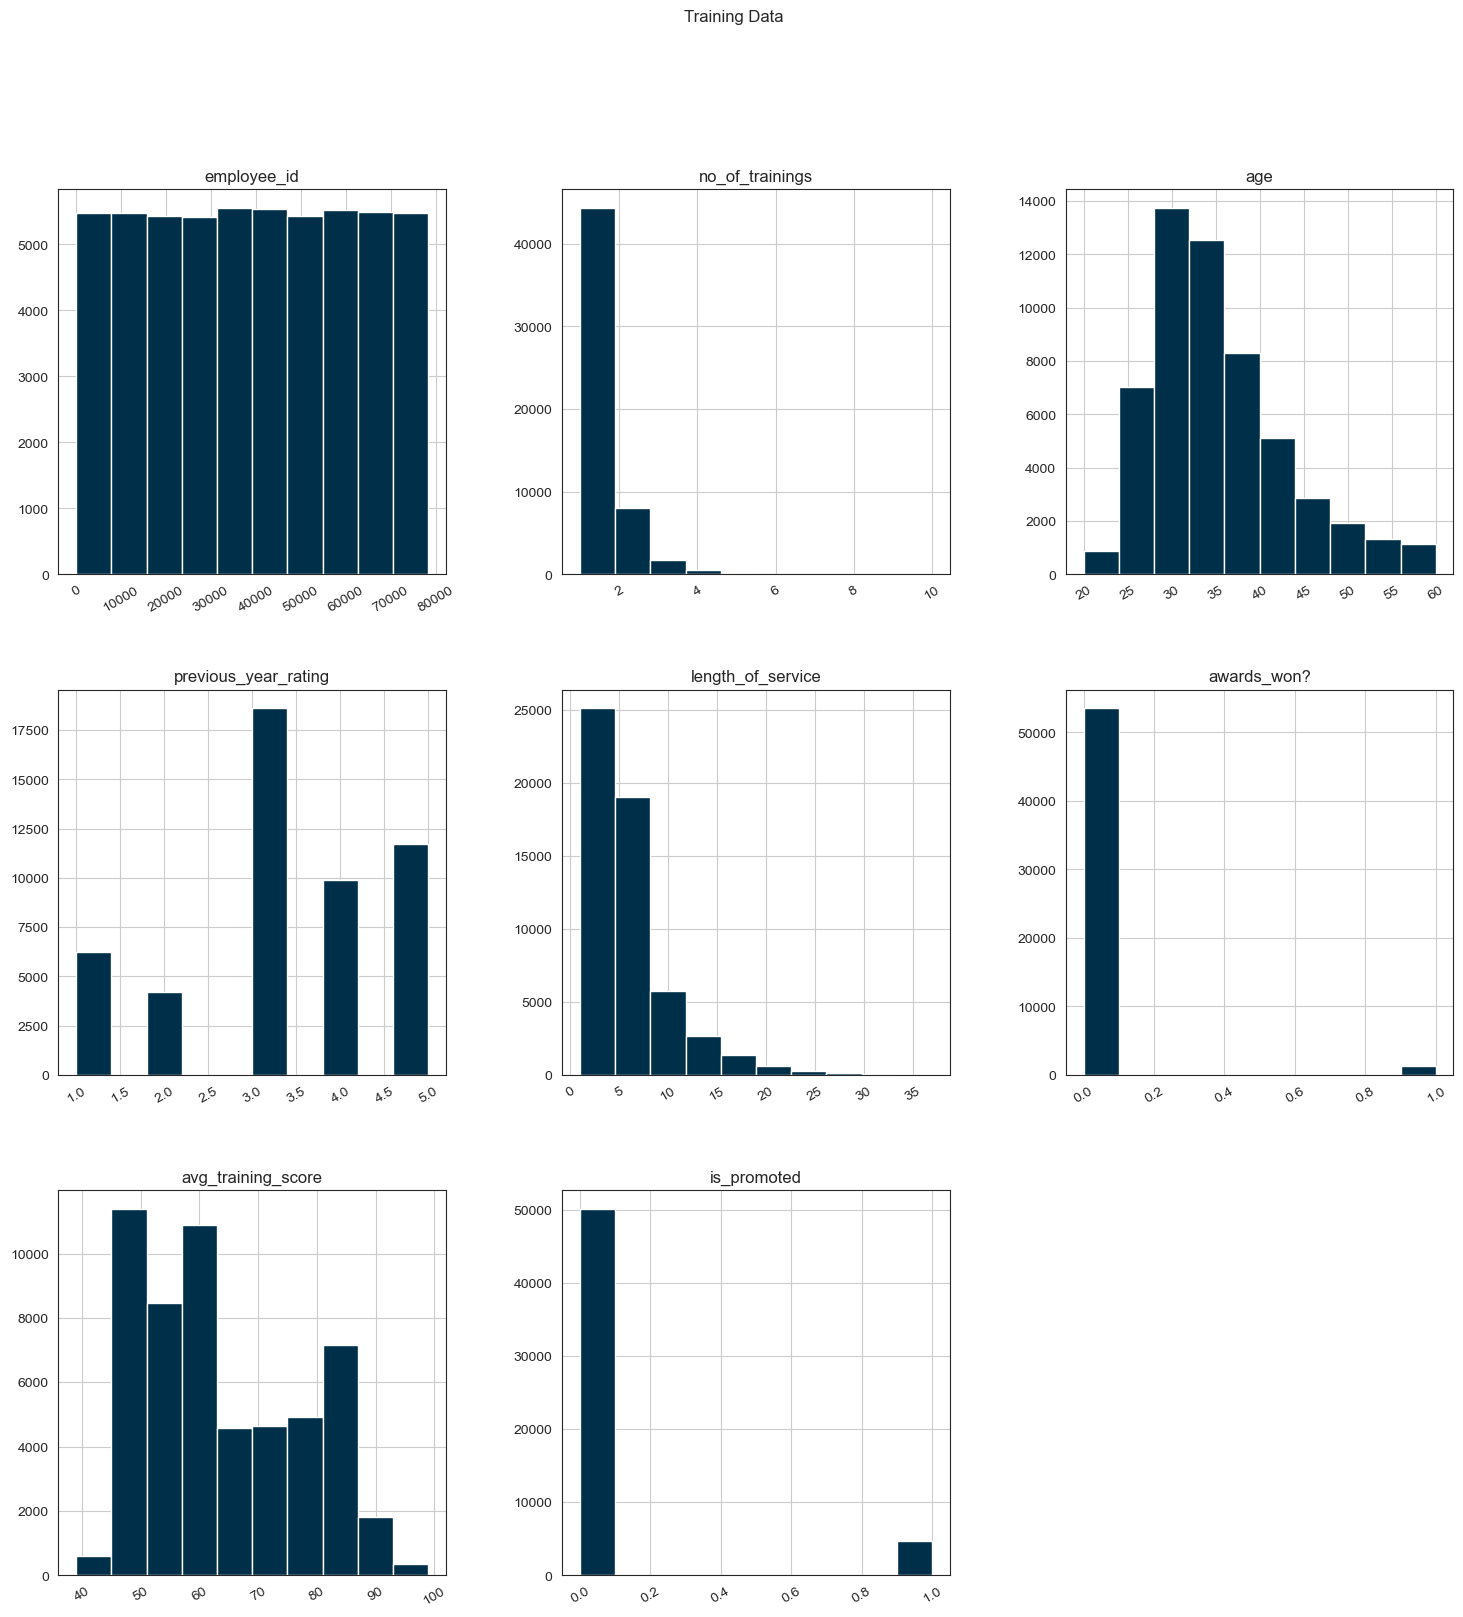

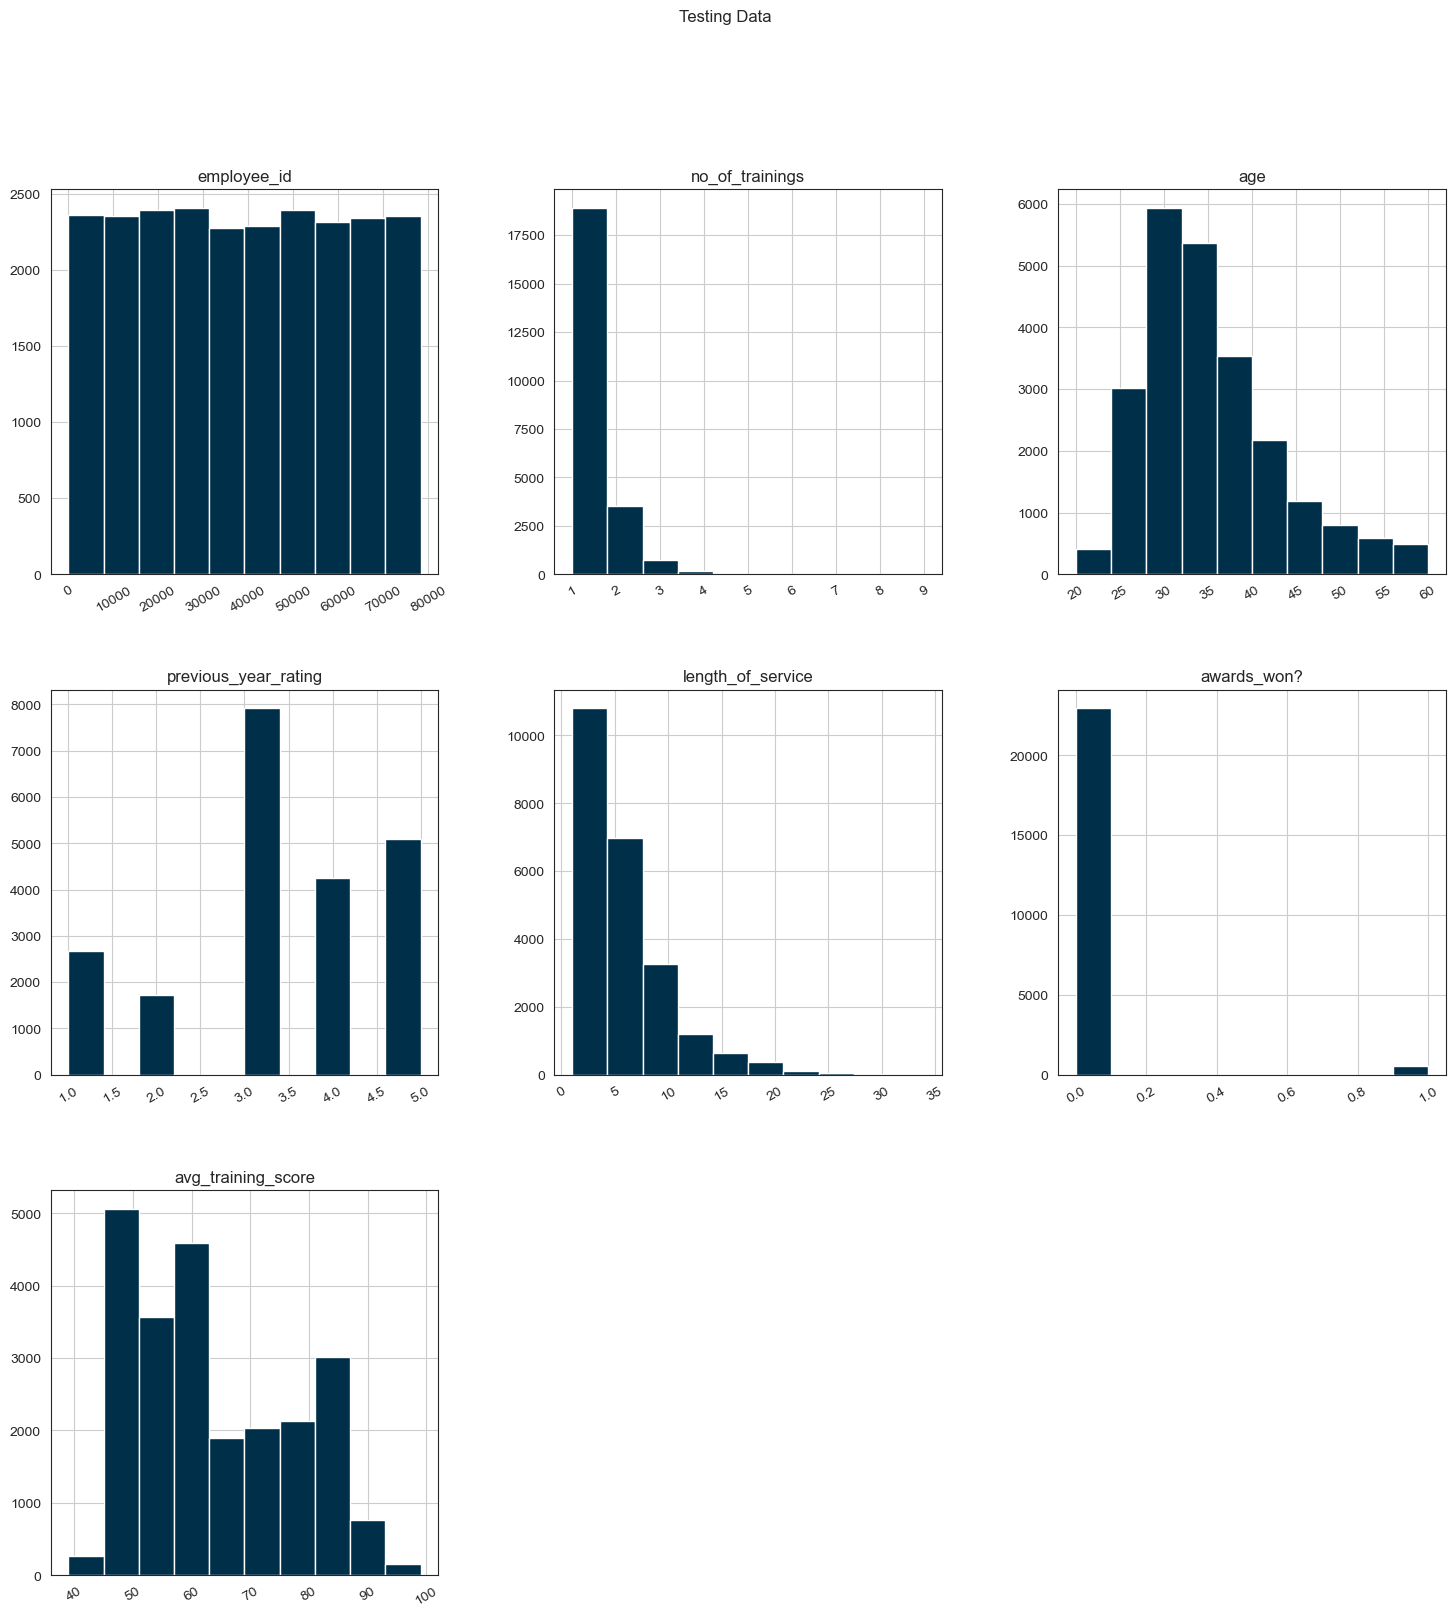

In [49]:
train.hist(figsize=(18,18), xrot=30)
plt.suptitle('Training Data')
plt.show();

test.hist(figsize=(18,18), xrot=30)
plt.suptitle('Testing Data')
plt.show();

In [50]:
train['is_promoted'].value_counts()

0    50140
1     4668
Name: is_promoted, dtype: int64

In [51]:
#review some categorical columns
cat_cols = train.select_dtypes(include=['object']).columns

for c in cat_cols:
    train[c].value_counts(normalize = True)
    train[c].value_counts()

for c in cat_cols:
    test[c].value_counts(normalize = True)
    test[c].value_counts()

Sales & Marketing    0.307254
Operations           0.207050
Technology           0.130236
Procurement          0.130236
Analytics            0.097650
Finance              0.046271
HR                   0.044118
Legal                0.018957
R&D                  0.018227
Name: department, dtype: float64

Sales & Marketing    16840
Operations           11348
Technology            7138
Procurement           7138
Analytics             5352
Finance               2536
HR                    2418
Legal                 1039
R&D                    999
Name: department, dtype: int64

region_2     0.225204
region_22    0.117282
region_7     0.088363
region_15    0.051233
region_13    0.048314
region_26    0.041235
region_31    0.035305
region_4     0.031072
region_27    0.030269
region_16    0.026730
region_28    0.024048
region_11    0.023993
region_23    0.021438
region_29    0.018136
region_32    0.017242
region_19    0.015947
region_20    0.015509
region_14    0.015089
region_25    0.014943
region_17    0.014523
region_5     0.013976
region_6     0.012589
region_30    0.011987
region_8     0.011951
region_10    0.011823
region_1     0.011130
region_24    0.009269
region_12    0.009123
region_9     0.007663
region_21    0.007499
region_3     0.006313
region_34    0.005328
region_33    0.004908
region_18    0.000566
Name: region, dtype: float64

region_2     12343
region_22     6428
region_7      4843
region_15     2808
region_13     2648
region_26     2260
region_31     1935
region_4      1703
region_27     1659
region_16     1465
region_28     1318
region_11     1315
region_23     1175
region_29      994
region_32      945
region_19      874
region_20      850
region_14      827
region_25      819
region_17      796
region_5       766
region_6       690
region_30      657
region_8       655
region_10      648
region_1       610
region_24      508
region_12      500
region_9       420
region_21      411
region_3       346
region_34      292
region_33      269
region_18       31
Name: region, dtype: int64

Bachelor's          0.699803
Master's & above    0.284834
Below Secondary     0.015363
Name: education, dtype: float64

Bachelor's          36669
Master's & above    14925
Below Secondary       805
Name: education, dtype: int64

m    0.702379
f    0.297621
Name: gender, dtype: float64

m    38496
f    16312
Name: gender, dtype: int64

other       0.555503
sourcing    0.423661
referred    0.020836
Name: recruitment_channel, dtype: float64

other       30446
sourcing    23220
referred     1142
Name: recruitment_channel, dtype: int64

Sales & Marketing    0.311409
Operations           0.202810
Procurement          0.128565
Technology           0.128182
Analytics            0.098723
Finance              0.046445
HR                   0.046190
Legal                0.018944
R&D                  0.018731
Name: department, dtype: float64

Sales & Marketing    7315
Operations           4764
Procurement          3020
Technology           3011
Analytics            2319
Finance              1091
HR                   1085
Legal                 445
R&D                   440
Name: department, dtype: int64

region_2     0.225585
region_22    0.116603
region_7     0.084376
region_13    0.049681
region_15    0.048106
region_26    0.043040
region_31    0.035930
region_4     0.032993
region_27    0.030226
region_28    0.025330
region_16    0.025117
region_11    0.024308
region_23    0.021967
region_32    0.018433
region_29    0.017625
region_19    0.017454
region_17    0.015368
region_14    0.014900
region_5     0.014559
region_25    0.014347
region_20    0.013878
region_6     0.012686
region_30    0.011622
region_8     0.011452
region_10    0.011452
region_1     0.010132
region_24    0.009323
region_12    0.009153
region_9     0.007663
region_21    0.007620
region_34    0.006599
region_3     0.006258
region_33    0.005364
region_18    0.000851
Name: region, dtype: float64

region_2     5299
region_22    2739
region_7     1982
region_13    1167
region_15    1130
region_26    1011
region_31     844
region_4      775
region_27     710
region_28     595
region_16     590
region_11     571
region_23     516
region_32     433
region_29     414
region_19     410
region_17     361
region_14     350
region_5      342
region_25     337
region_20     326
region_6      298
region_30     273
region_8      269
region_10     269
region_1      238
region_24     219
region_12     215
region_9      180
region_21     179
region_34     155
region_3      147
region_33     126
region_18      20
Name: region, dtype: int64

Bachelor's          0.693712
Master's & above    0.289633
Below Secondary     0.016655
Name: education, dtype: float64

Bachelor's          15578
Master's & above     6504
Below Secondary       374
Name: education, dtype: int64

m    0.706513
f    0.293487
Name: gender, dtype: float64

m    16596
f     6894
Name: gender, dtype: int64

other       0.556748
sourcing    0.424053
referred    0.019200
Name: recruitment_channel, dtype: float64

other       13078
sourcing     9961
referred      451
Name: recruitment_channel, dtype: int64

In [52]:
train['awards_won?'].value_counts(normalize = True)
train['awards_won?'].value_counts()

test['awards_won?'].value_counts(normalize = True)
test['awards_won?'].value_counts()

0    0.976828
1    0.023172
Name: awards_won?, dtype: float64

0    53538
1     1270
Name: awards_won?, dtype: int64

0    0.977224
1    0.022776
Name: awards_won?, dtype: float64

0    22955
1      535
Name: awards_won?, dtype: int64

In [53]:
#drop unnecessary columns: region (there are A LOT of them) and employee id
train.drop(['region', 'employee_id'], axis = 1, inplace = True)
test.drop(['region', 'employee_id'], axis = 1, inplace = True)

In [54]:
#indicate missing data
train['has_rating'] = train['previous_year_rating'].apply(lambda x: 0 if pd.isnull(x) else 1)
train['has_education'] = train['education'].apply(lambda x: 0 if pd.isnull(x) else 1)

test['has_rating'] = test['previous_year_rating'].apply(lambda x: 0 if pd.isnull(x) else 1)
test['has_education'] = test['education'].apply(lambda x: 0 if pd.isnull(x) else 1)


## EDA 


In [55]:

def make_cat_plots(df, x_var):
    target_cat_cols = ['education', 'gender', 'recruitment_channel', 'department', 'awards_won?', 'has_rating', 'has_education']


    # define subplot grid
    fig, axs = plt.subplots(nrows=4, ncols=2, figsize=(15, 12))
    plt.subplots_adjust(hspace=0.5)
    fig.suptitle("Promotion Rates by Categorical Variables", fontsize=18, y=0.95)
    # create empty list to store labels for legend
    labels = []

    # loop through columns and axes
    for col, ax in zip(target_cat_cols, axs.ravel()):
        # filter df for ticker and plot on specified axes
        # Group by variables and get proportions
        grouped_df = df.groupby([col, x_var]).size().groupby(level=0).apply(lambda x: round(x / x.sum()*100, 0)).reset_index(name='proportion')

        # Pivot table to format data for plotting
        pivot_df = grouped_df.pivot(index= col, columns=x_var, values='proportion')

        # Plot bar chart
        pivot_df.plot(kind='bar', rot=20, ax=ax)

        # Add value labels to bars
        for p in ax.containers:
            ax.bar_label(p, label_type='edge', labels=[f"{int(round(height))}%" for height in p.datavalues], fontsize=10)

        # Set x and y-axis labels
        ax.set_xlabel('')
        ax.set_ylabel('Percentage of Employees')


        # Append the labels for this subplot to the list
        labels.append(pivot_df.columns.to_list())
        # Remove legend
        ax.legend().set_visible(False)

        # Set the title for the subplot
        ax.set_title(f"{col}")
        ax.grid(False)
        
    # Flatten the list of labels and remove duplicates
    flat_labels = list(set([item for sublist in labels for item in sublist]))

    # Show legend at the top right of the figure
    fig.legend(labels=flat_labels, loc='upper right', title=x_var)

    plt.show();

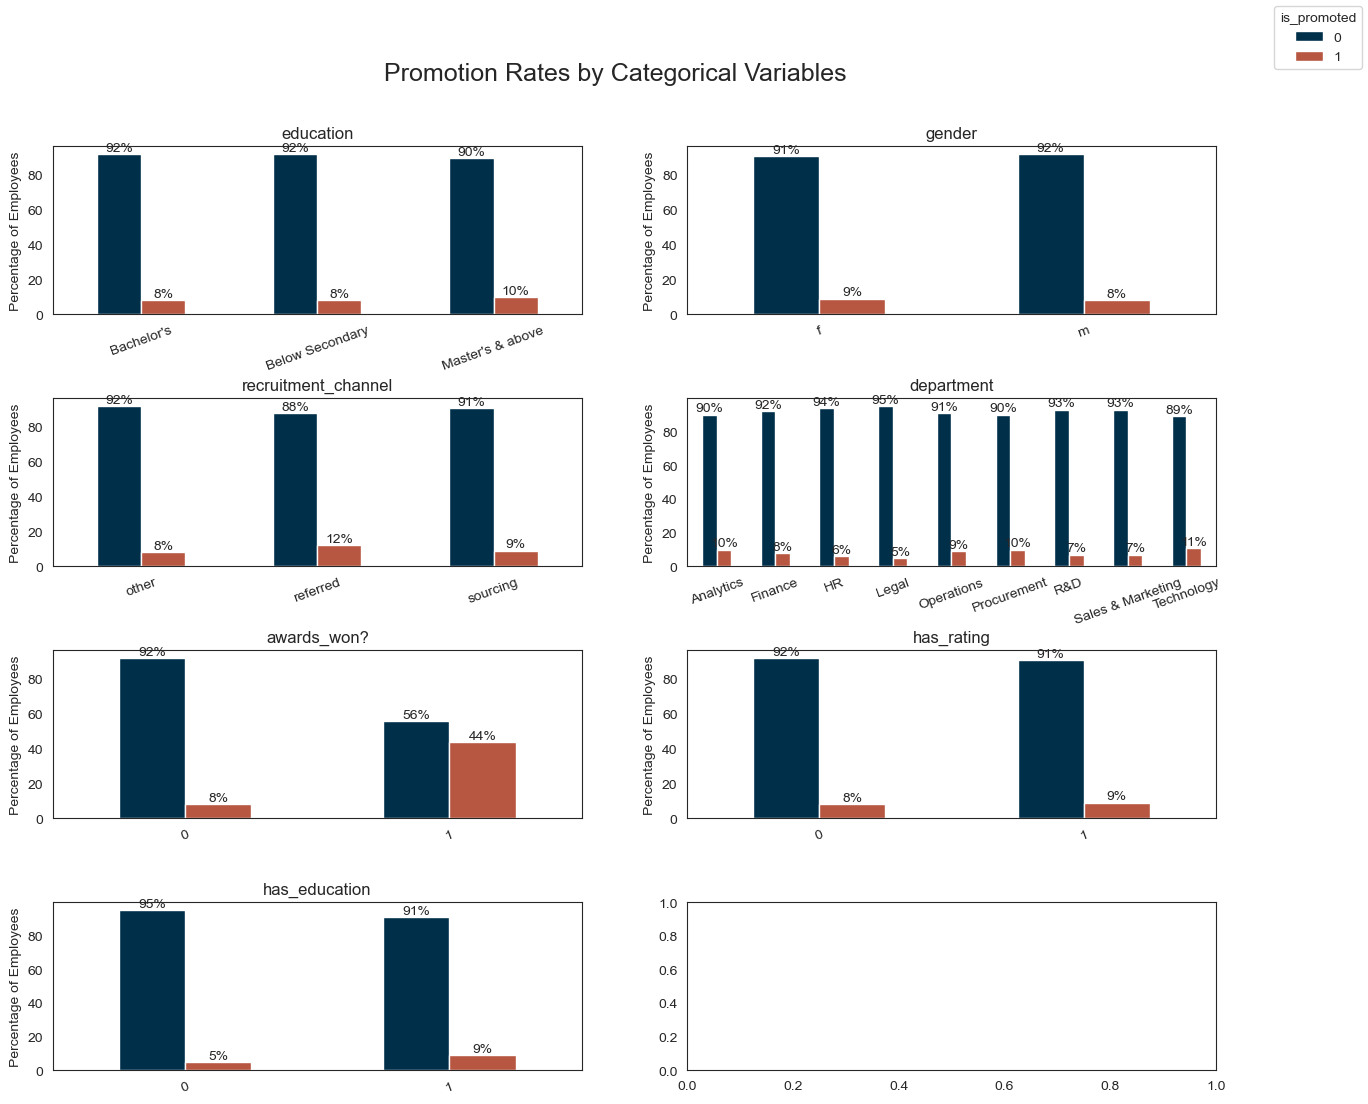

In [56]:
make_cat_plots(train, 'is_promoted')

Observations:
* Promotion rates are about equal by education level, slightly higher for Master's level.
* Promotion rates are nearly equal by gender.
* Referrals have a higher promotion rate.
* Employees who have won awards have much higher promotion rates.
* HR and Legal have lower promo rates while Analytics, Procurement, and Tech have higher rates.

### Distribution of numeric variables by promos status

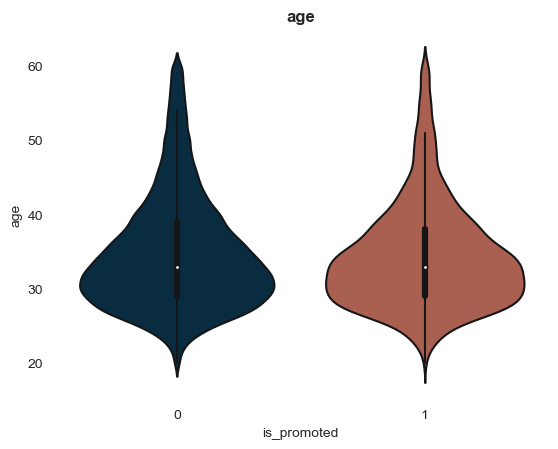

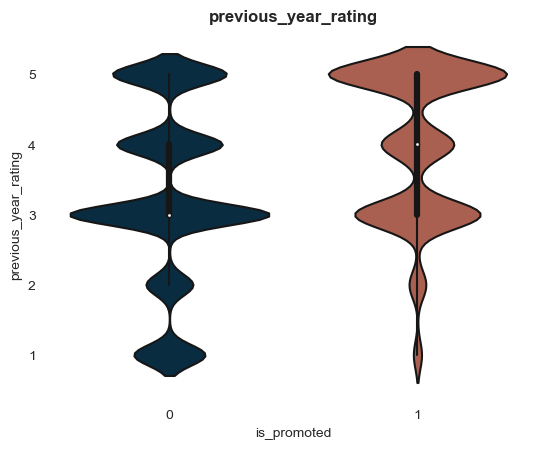

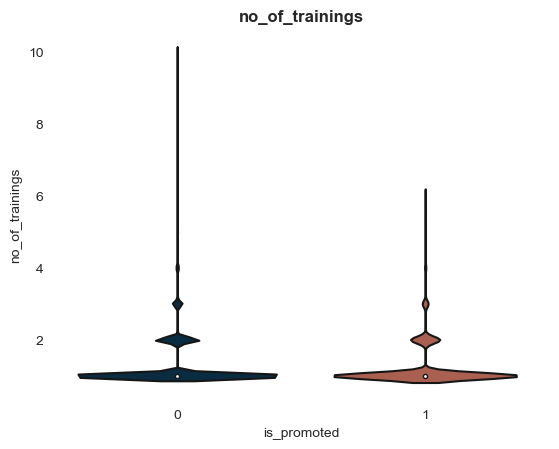

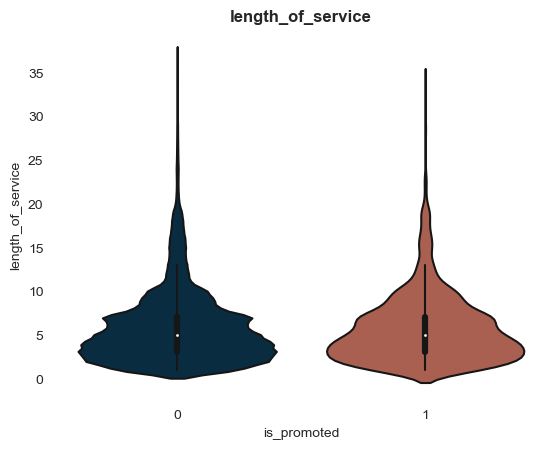

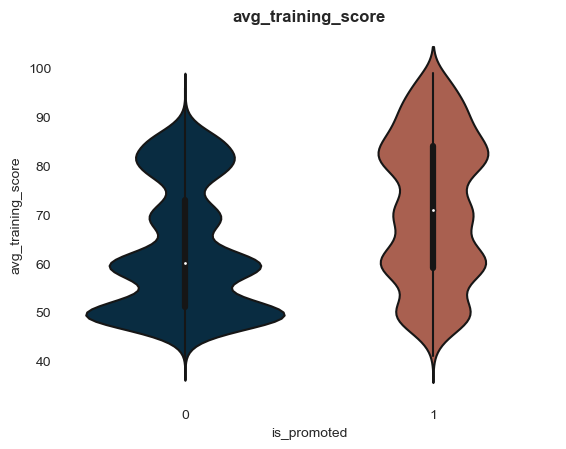

In [57]:
target_num_cols = ['age', 'previous_year_rating', 'no_of_trainings', 'length_of_service',
                   'avg_training_score']

def make_violin(df, x_var, y_var):
    sns.set_palette(["#002f4a", "#b85741"])
    ax = sns.violinplot(data= df, x = x_var, y = y_var, split= True)
    plt.title(y_var, weight= 'bold')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    plt.show();

for col in target_num_cols:
    make_violin(train, 'is_promoted', col)

* Promoted employees appear to have a higher average training score and higher performance rating.

Observations:
* Promoted employees tend to have higher average training scores, are more likely to have won an award, and have higher previous year ratings.
* Training score seems to be more important than number of trainings.

## Data Cleaning & Feature Prep
I need to handle missing data in the performance rating and education variables. For the purposes of determining predictors of promotion, I'll impute the missing values. However, the handling of missing data should be revisited if this modeling is used to 'shortlist' promo candidates. I'd want to better understand why the data is missing. 
* For performance rating, I'd be more concerned because this is likely a driver of promos. Imputed missing data may not be appropriate and those with missing data may need to be manually reviewed for short-listing (are they missing perf data because they were on leave?)
* For education, I might drop this feature entirely if using this modeling to short-list candidates. I don't anticipate it having as much predictive value and if making actual promo decisions based on modeling, we don't want to be 'guessing' data about employees.

**Imputation Method**
* I will impute the median performance rating and the most frequent education level.
* Two new features will be generated that will flag whether the data was imputed or not and included in modeling.

In [58]:
def clean_data(df):
    df_clean = df.copy()

    imputer1 = SimpleImputer(strategy='median')
    imputer2 = SimpleImputer(strategy = 'most_frequent')

    df_clean['previous_year_rating'] = imputer1.fit_transform(df_clean[['previous_year_rating']])
    df_clean['education'] = imputer2.fit_transform(df_clean[['education']])

    return df_clean


In [59]:
train_clean = clean_data(train)
test_clean = clean_data(test)

train_clean.info()
test_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54808 entries, 0 to 54807
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   department            54808 non-null  object 
 1   education             54808 non-null  object 
 2   gender                54808 non-null  object 
 3   recruitment_channel   54808 non-null  object 
 4   no_of_trainings       54808 non-null  int64  
 5   age                   54808 non-null  int64  
 6   previous_year_rating  54808 non-null  float64
 7   length_of_service     54808 non-null  int64  
 8   awards_won?           54808 non-null  int64  
 9   avg_training_score    54808 non-null  int64  
 10  is_promoted           54808 non-null  int64  
 11  has_rating            54808 non-null  int64  
 12  has_education         54808 non-null  int64  
dtypes: float64(1), int64(8), object(4)
memory usage: 5.4+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23490 entries,

I'm going to keep all of the features for this data set since their aren't too many. Before, modeling, I'll prep the features.

In [60]:
def encode_vars(df):
    df_dummies = df.copy()
    df_dummies['gender'] = df_dummies['gender'].apply(lambda x: 1 if x == 'm' else 0)
    df_dummies['education'] = df_dummies['education'].apply(lambda x: 0 if x == 'Below Secondary' else
                                                                            1 if x == "Bachelor's"
                                                                            else 2)
    #one-hot encoding
    df_dummies = pd.get_dummies(df_dummies, columns=['recruitment_channel', 'department'], drop_first=True)

    return df_dummies

In [61]:
train_dummies = encode_vars(train_clean)
test_dummies = encode_vars(test_clean)

train_dummies.head()
test_dummies.head()

,education,gender,no_of_trainings,age,previous_year_rating,length_of_service,awards_won?,avg_training_score,is_promoted,has_rating,has_education,recruitment_channel_referred,recruitment_channel_sourcing,department_Finance,department_HR,department_Legal,department_Operations,department_Procurement,department_R&D,department_Sales & Marketing,department_Technology
0,2,0,1,35,5.0,8,0,49,0,1,1,0,1,0,0,0,0,0,0,1,0
1,1,1,1,30,5.0,4,0,60,0,1,1,0,0,0,0,0,1,0,0,0,0
2,1,1,1,34,3.0,7,0,50,0,1,1,0,1,0,0,0,0,0,0,1,0
3,1,1,2,39,1.0,10,0,50,0,1,1,0,0,0,0,0,0,0,0,1,0
4,1,1,1,45,3.0,2,0,73,0,1,1,0,0,0,0,0,0,0,0,0,1


,education,gender,no_of_trainings,age,previous_year_rating,length_of_service,awards_won?,avg_training_score,has_rating,has_education,recruitment_channel_referred,recruitment_channel_sourcing,department_Finance,department_HR,department_Legal,department_Operations,department_Procurement,department_R&D,department_Sales & Marketing,department_Technology
0,1,1,1,24,3.0,1,0,77,0,1,0,1,0,0,0,0,0,0,0,1
1,1,0,1,31,3.0,5,0,51,1,1,0,0,0,1,0,0,0,0,0,0
2,1,1,1,31,1.0,4,0,47,1,1,0,0,0,0,0,0,0,0,1,0
3,1,0,3,31,2.0,9,0,65,1,1,0,0,0,0,0,0,1,0,0,0
4,1,1,1,30,4.0,7,0,61,1,1,0,1,1,0,0,0,0,0,0,0


## Data Modeling
### Model 1. xgBoost
Because the data is imbalanced, I'll employ an ensemble approach that is known to perform well on imbalanced data.
Cross validation will be used to evaluate the model. Because the test data has no promotion data, additional EDA will be performed to review how the model made classifications.


In [62]:
#Data split
X = train_dummies.drop('is_promoted', axis = 1)
y = train_dummies['is_promoted']
X_test = test_dummies
#train test split (because we have an actual test set, naming the 20% set a validation set)
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size = .2, random_state = 42)

In [63]:
# Define cross validation function
def kfold_cv(model, X, y, splits = 10, repeats = 3):
    # Set up repeated kfolds for cross validation
    # By default, data will be split into ten folds that will each be used as training and testing sets to evaluate reliability
    # (and this is repeated 3 times), making us more confident in the generalizability of the model
    cv = RepeatedKFold(n_splits=splits, n_repeats=repeats, random_state=42)

    # set up scorer
    # selecting some standard evaluation measures to give an overview of model performance
    scoring = {
        'accuracy': make_scorer(accuracy_score), # What % of predictions was the model correct on?
        'sensitivity': make_scorer(recall_score), # aka recall or true positive rate; What % correctly identified as turnover?
                                                # true positive / all actual positive
        'specificity': make_scorer(recall_score,pos_label=0), # aka true negative rate; What % correctly identified as stayer?
                                                            # true negative / all actual negative
        'precision': make_scorer(precision_score), # aka positive predictive value; of all predicted as leavers, what % were correct?
                                                # true positive / all pred. positive
        'AUC': make_scorer(roc_auc_score), # area under ROC curve; ROC plots illustrates trade off between true pos rate and false pos rate
                                            # higher value under this curve represents lower trade off/better performing model
                }
    
    #Cross validate and report performance
    scores = cross_validate(model, X, y, scoring= scoring, cv=cv, n_jobs=-1)

    #report performance
    print('Accuracy: %.3f (%.3f)' % (np.mean(scores['test_accuracy']), np.std(scores['test_accuracy'])))
    print('Sensitivity: %.3f (%.3f)' % (np.mean(scores['test_sensitivity']), np.std(scores['test_sensitivity'])))
    print('Specificity: %.3f (%.3f)' % (np.mean(scores['test_specificity']), np.std(scores['test_specificity'])))
    print('Precision: %.3f (%.3f)' % (np.mean(scores['test_precision']), np.std(scores['test_precision'])))
    print('AUC: %.3f (%.3f)' % (np.mean(scores['test_AUC']), np.std(scores['test_AUC'])))

In [64]:
#use y train to get estimate of best value for scale_pos_weight
#this is a weight that is applied to positive classifications that scales the gradient 
#scaling the gradient encourages the model to over-correct for errors when classifying the positive outcome (turnover)
y_train.value_counts()

#scale_pos_weight = num stayers/num leavers
estimate = 40086/3760
estimate

xgModel = XGBClassifier(scale_pos_weight=estimate,
                        n_estimators=500
                        )

xgModel.fit(X_train, y_train,
            # allows the model to stop before the 500 iterations if validation stops improving
            early_stopping_rounds=5,
            #provide validation set to allow for early stopping
              eval_set=[(X_valid, y_valid)],
              verbose=False)

kfold_cv(xgModel, X_train, y_train)

# predict on original, unseen test set
xg_pred = xgModel.predict(X_test)

0    40086
1     3760
Name: is_promoted, dtype: int64

10.661170212765958

c:\Users\maris\anaconda3\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=500, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

Accuracy: 0.861 (0.006)
Sensitivity: 0.493 (0.032)
Specificity: 0.896 (0.005)
Precision: 0.308 (0.021)
AUC: 0.695 (0.017)


<BarContainer object of 20 artists>

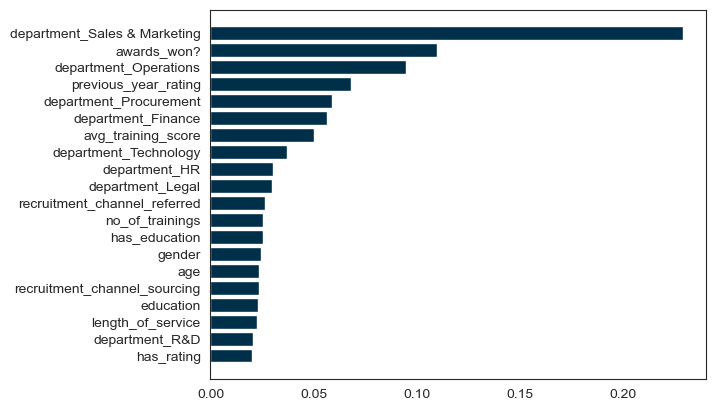

In [65]:
sort_index = xgModel.feature_importances_.argsort()

plt.barh(X_train.columns[sort_index], xgModel.feature_importances_[sort_index])

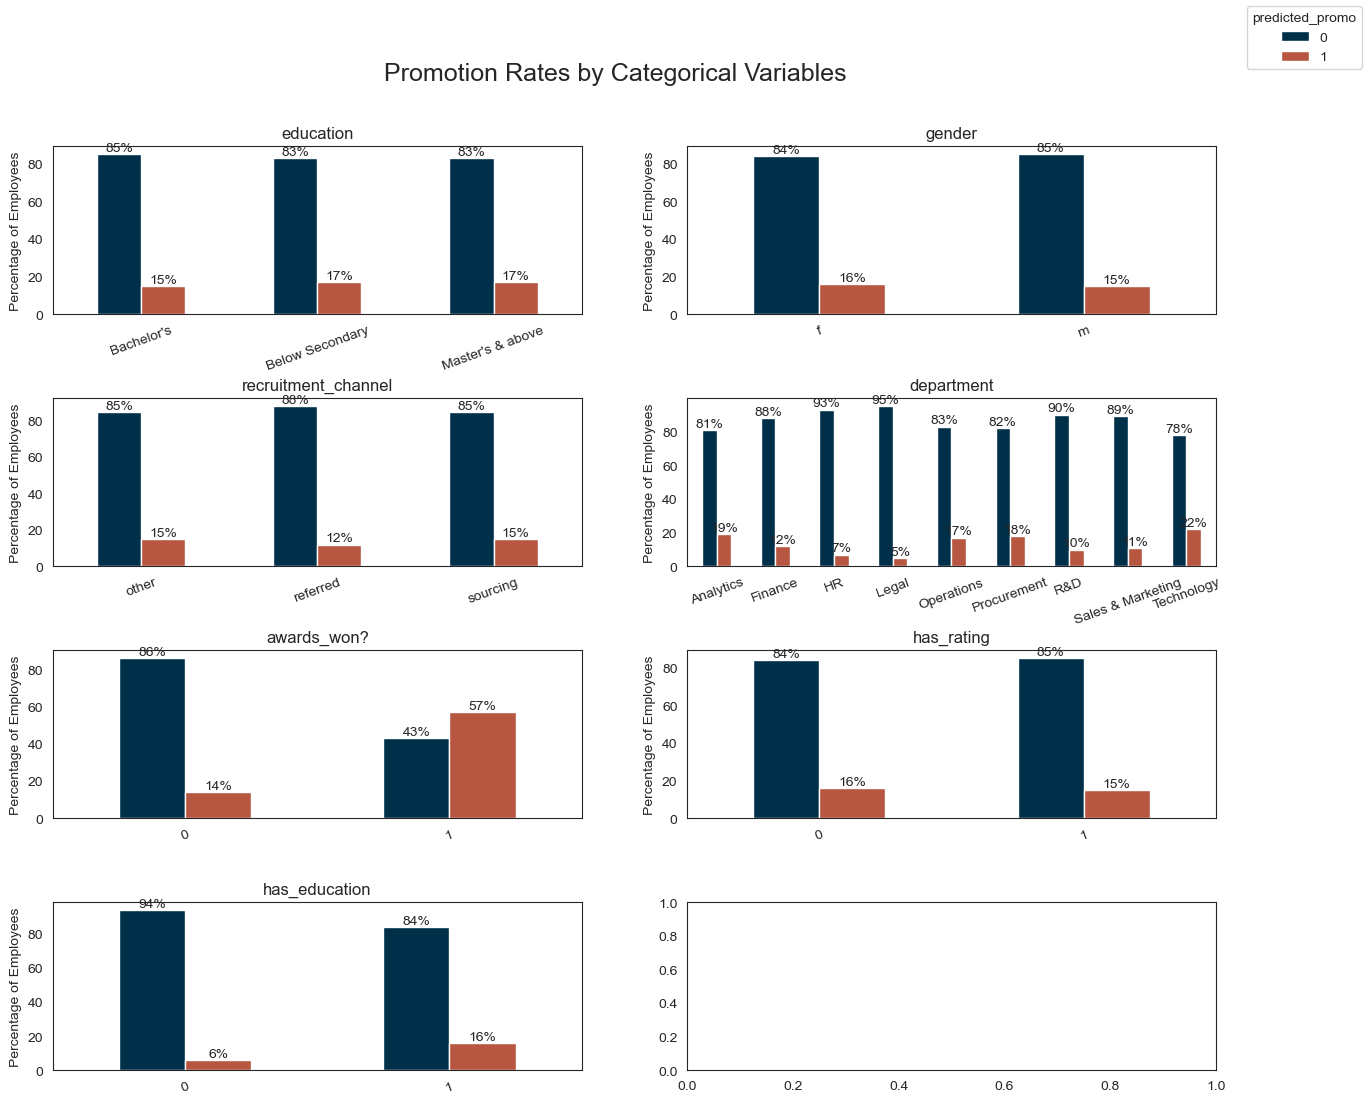

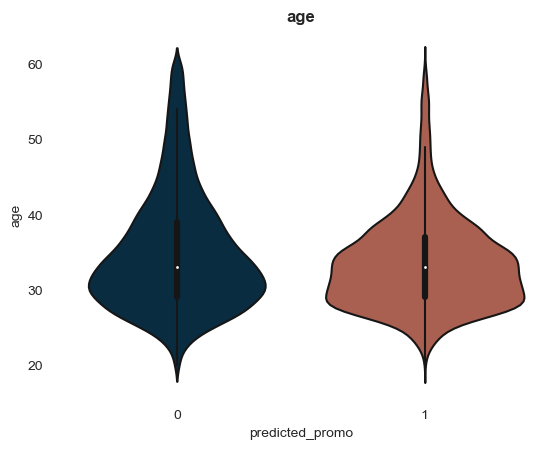

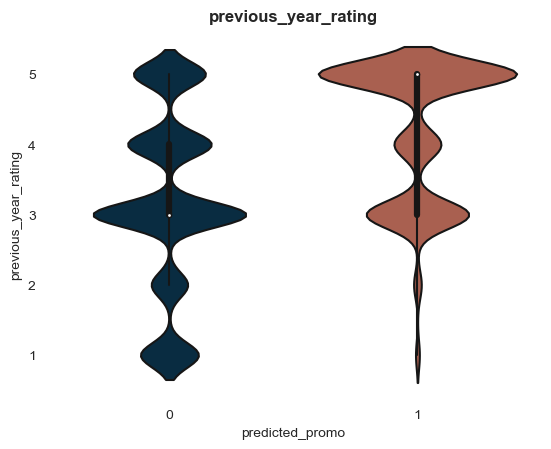

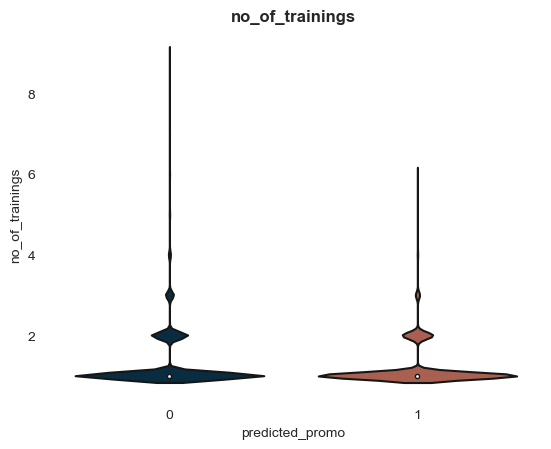

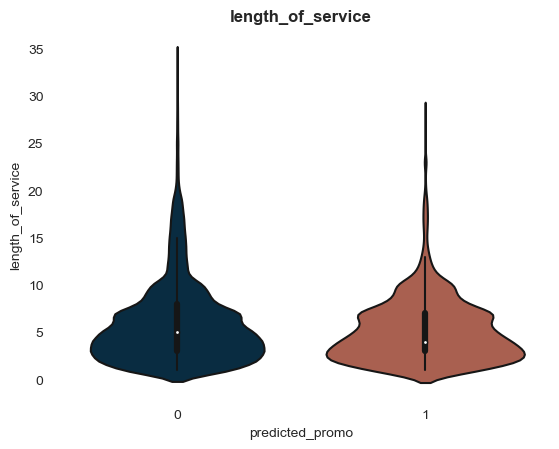

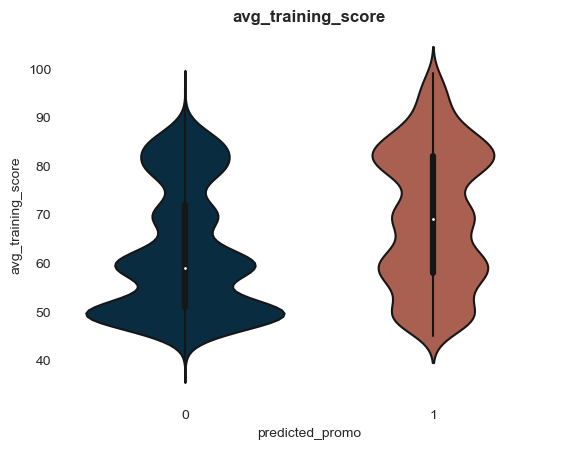

In [66]:
xg_pred = xgModel.predict(X_test)

test_xg = test.copy()
test_xg['predicted_promo'] = xg_pred

make_cat_plots(test_xg, 'predicted_promo')

for col in target_num_cols:
    make_violin(test_xg, 'predicted_promo', col)

### Models 2 and 3: Random Forest
For comparison, we'll also run random forest. The first random forest will be on the imbalance data, and the second random forest will try balancing the data using SMOTE resampling.

In [67]:
#Define function for evaluating our model
def eval_model(predictions, actual):
    #Evaluate model
    #print confusion matrix
    cf = pd.DataFrame(confusion_matrix(y_true = actual, y_pred = predictions))

    # calculate scores from confusion matrix values
    t_neg, f_pos, f_neg, t_pos = confusion_matrix(y_true = actual, y_pred = predictions).ravel()

    #accuracy
    acc = accuracy_score(y_true = actual, y_pred = predictions)
    print(acc)
    #sensitivity
    sens = recall_score(y_true = actual, y_pred = predictions)
    #specifiction
    spec = t_neg / (t_neg+f_pos)
    #precision
    prec = precision_score(y_true = actual, y_pred = predictions)
    #ROC AUC
    auc = roc_auc_score(y_true = actual, y_score = predictions)

    #report performance
    print('Confusion Matrix:')
    print(cf)
    print('Accuracy: %.3f' % (acc))
    print('Sensitivity: %.3f' % (sens))
    print('Specificty: %.3f' % (spec))
    print('Precision: %.3f' % (spec))
    print('AUC: %.3f' % (auc))

In [68]:
rf = RandomForestClassifier(random_state=42)

rf.fit(X_train, y_train)

pred = rf.predict(X_valid)

eval_model(pred, y_valid)

RandomForestClassifier(random_state=42)

0.9338624338624338
Confusion Matrix:
      0    1
0  9940  114
1   611  297
Accuracy: 0.934
Sensitivity: 0.327
Specificty: 0.989
Precision: 0.989
AUC: 0.658


* We have high accuracy but low sensitivity; unsurprising given class imbalance. Before moving on, let's look at feature importance.

In [69]:
importances = mutual_info_classif(X, y)

feature_rank = pd.DataFrame(importances, X.columns)

feature_rank.sort_values(by=[0], ascending = False)

,0
avg_training_score,0.030650
previous_year_rating,0.016321
awards_won?,0.011437
has_rating,0.010564
has_education,0.010455
no_of_trainings,0.008161
education,0.005919
gender,0.004071
recruitment_channel_sourcing,0.003039
department_Technology,0.002289


Now we'll try a SMOTE model to try to improve sensitivity. If that cross-validation yields better results, we'll use it on the imbalanced test data.

In [70]:
X_sm, y_sm = SMOTE(sampling_strategy=1, random_state = 42).fit_resample(X, y)

print(X_sm.shape)
print(y_sm.shape)
y_sm.value_counts(normalize=True)

#train test split (because we have an actual test set, naming the 20% set a validation set)
X_train_sm, X_valid_sm, y_train_sm, y_valid_sm = train_test_split(X_sm, y_sm, test_size = .2, random_state = 42)



(100280, 20)
(100280,)


0    0.5
1    0.5
Name: is_promoted, dtype: float64

In [71]:
rf_sm = RandomForestClassifier(random_state=42)

rf_sm.fit(X_train_sm, y_train_sm)

pred_sm = rf_sm.predict(X_valid_sm)



RandomForestClassifier(random_state=42)

In [72]:
eval_model(pred_sm, y_valid_sm)

0.9376246509772637
Confusion Matrix:
      0     1
0  9506   691
1   560  9299
Accuracy: 0.938
Sensitivity: 0.943
Specificty: 0.932
Precision: 0.932
AUC: 0.938


* This performance looks great. Let's test with the unseen and imbalanced test data.

In [73]:
test_pred = rf.predict(X_test)

* View feature importance.

In [74]:
importances_sm = mutual_info_classif(X_sm, y_sm)

feature_rank_sm = pd.DataFrame(importances_sm, X_sm.columns)

feature_rank_sm.sort_values(by=[0], ascending = False)

,0
previous_year_rating,0.204553
avg_training_score,0.062490
no_of_trainings,0.022858
recruitment_channel_sourcing,0.018768
gender,0.014964
has_rating,0.013398
has_education,0.012843
education,0.010872
department_HR,0.008656
department_Sales & Marketing,0.005559


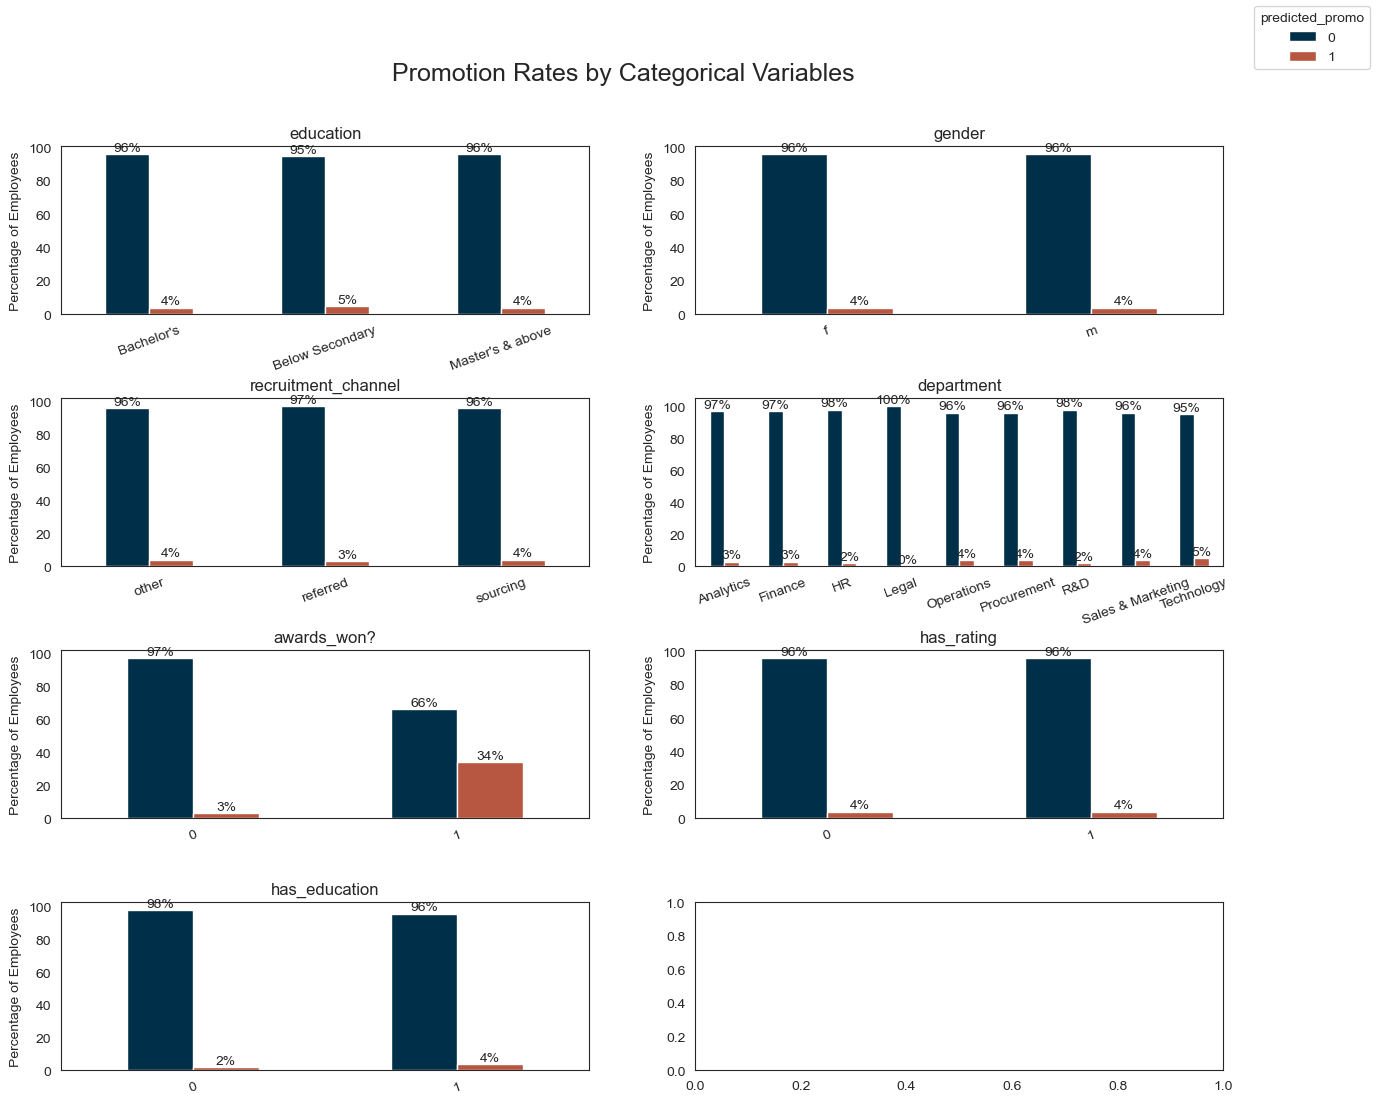

In [76]:

test['predicted_promo'] = test_pred
make_cat_plots(test, 'predicted_promo')

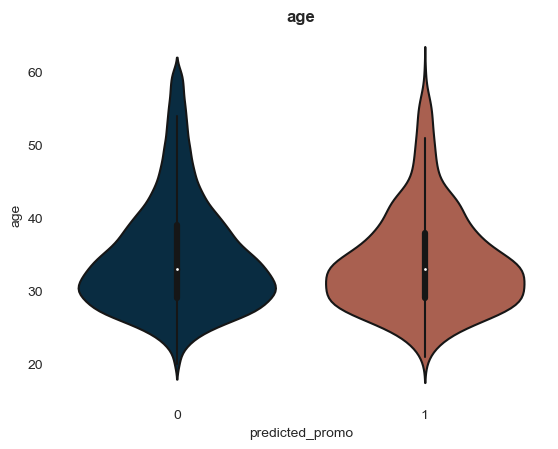

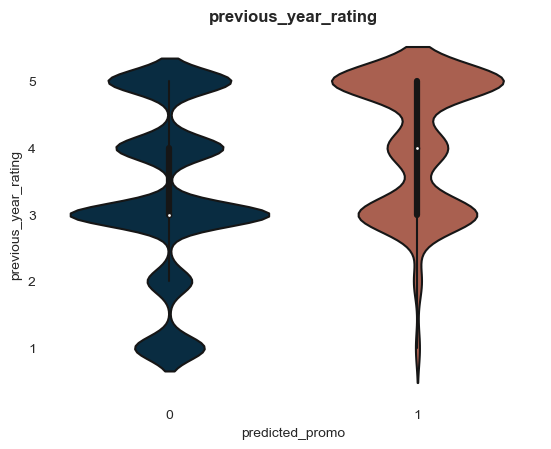

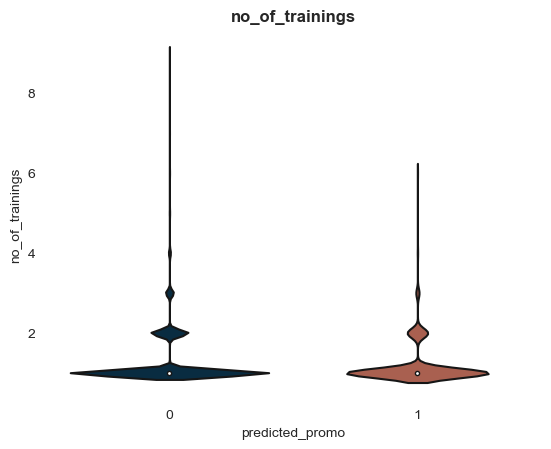

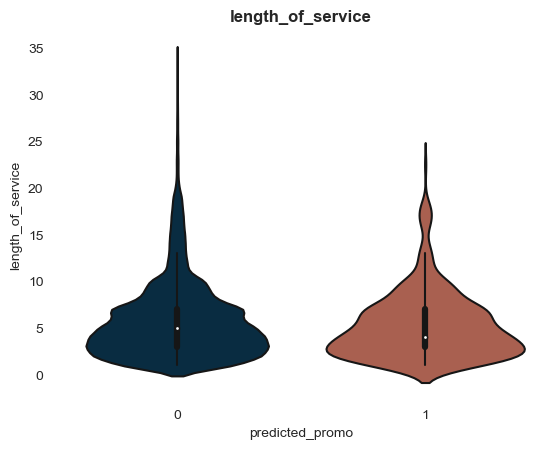

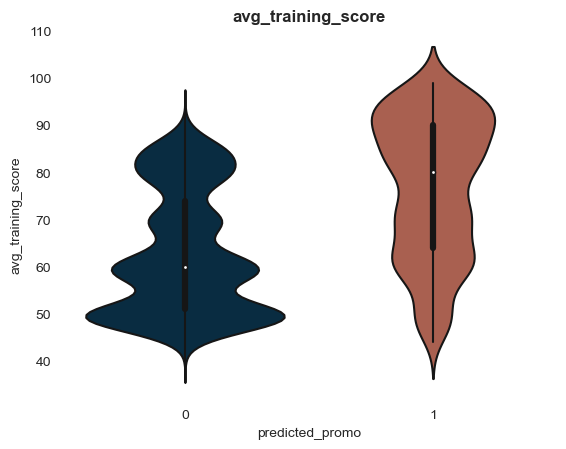

In [77]:
target_num_cols = ['age', 'previous_year_rating', 'no_of_trainings', 'length_of_service',
                   'avg_training_score']



for col in target_num_cols:
    make_violin(test, 'predicted_promo', col)

## Key Takeaways and Next Steps
* The initial xgBoost model appears to be the most effective as it maximizes sensitivity and AUC. This is seen in the test EDA where the model is less conservative in predicting promotion. This is more ideal for use with shortlisting candidates.
* Promotions are best predicted by awards won, job performance ratings, and average training score.


**Modeling:**
Strengths:
* Intuitive and actionable drivers of promotion
* No preliminary evidence of bias toward protected classes

Areas for Further Development:
* Minimizing missing data
    * Imputing performance/education data would not be appropriate for use in short-listing promotion candidates
    * Employees with missing data may need manual review for candidacy
* Improving sensitivity
    * This model will underestimate the number of true promotions; also reflective of a perennial issue in selection and promotion in general (we’re good at identifying true positives, but who are we missing because they aren’t loud enough, being advocated for, are not being recognized for performance, etc?)
        * Experiment with additional ensemble approaches
            * Research key parameters
            * Employ grid search for hyperparameter tuning
